# Machine learning models

This notebook uses machine learning models to predict the probability of default for each customer in the application_test dataset. In particular, the Light Gradient Boosting (LightGBM) algorithm is used because it offers the best perfromance when compared to other types of machine learning models and is also much faster than XGBoost for this dataset.

The LightGBM model is optimized using a self-made Grid Search Cross-Validation algorithm that takes into account early stopping to prevent overfitting.

A neural network model is also created with Keras in order to generate a stacked model to further improve the predictions by the LightGBM model. This neural network model is optmized manually, taking into account early stopping to prevent overfitting.

Finally, a very simple stacked model is created as a weighted average of the probabilities generated using the two models. The optimum weights are calculated using the cross-validation predictions on the training data.

In [1]:
# Importing main modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
%matplotlib inline
pd.set_option('display.max_columns', 2000)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_predict, train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from keras import Sequential, regularizers
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, Callback


C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set(font_scale=1.4)
sns.set_style("white")

# Reverting to old color palette
pal = sns.color_palette("deep")
pal = pal.as_hex()
pal[1], pal[2], pal[3] = pal[2], pal[3], pal[1]
sns.set_palette(pal)

In [3]:
# Loading application dataframe from csv file 
application = pd.read_csv("./data/application.csv")

In [4]:
homecredit_columns_description = pd.read_csv("./data/HomeCredit_columns_description.csv", encoding="ISO-8859-1")

In [5]:
# Converting float 64 numbers to float 32 to reduce memory usage
float_cols = application.select_dtypes(include=["float64"]).columns;
application[float_cols] = application[float_cols].astype(np.float32);

In [6]:
application.info(max_cols = 2000);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 1145 columns):
AMT_ANNUITY                                                                                   356219 non-null float32
AMT_CREDIT                                                                                    356255 non-null float32
AMT_GOODS_PRICE                                                                               355977 non-null float32
AMT_INCOME_TOTAL                                                                              356255 non-null float32
AMT_REQ_CREDIT_BUREAU_DAY                                                                     308687 non-null float32
AMT_REQ_CREDIT_BUREAU_HOUR                                                                    308687 non-null float32
AMT_REQ_CREDIT_BUREAU_MON                                                                     308687 non-null float32
AMT_REQ_CREDIT_BUREAU_QRT                                    

In [7]:
# Creating dummy variables for categorical features

categorical_features = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",\
                        "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", \
                        "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", \
                        "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "FONDKAPREMONT_MODE", "HOUSETYPE_MODE", \
                        "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE", "mode_accompanied_client_list", \
                        "mode_client_type_list","mode_portfolio_list", "mode_channel_type_list", \
                        "mode_seller_type_list", "main_reason_refusal_list"]

application[categorical_features] = application[categorical_features].fillna("Unknown")
application = pd.get_dummies(application, columns = categorical_features);

# Another solution is label encoding with integers and passing list of categorical variables to LightGB

#le = LabelEncoder()
#application[categorical_features] = application[categorical_features].fillna("Unknown")
#for feature in categorical_features:
#    le.fit(application[feature])
#    application[feature] = le.transform(application[feature])


In [8]:
# Removing target from features
features_to_remove = ["TARGET", "train", "SK_ID_CURR"]

# Removing features with no variance
features_to_remove = features_to_remove + list(application.std()[application.std() == 0].index)

features = application.drop(features_to_remove, axis = 1).columns

In [9]:
# Splitting back the training and testing datasets
application_train = application[application["train"] == 1]
application_test = application[application["train"] == 0]

In [10]:
# Removing application dataframe from memory
del application

In [11]:
# Function to display memory usage of main datasets
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.2fMB"%(value/1e6))
        total += value
    print("%.2fMB"%(total/1e6))
    
show_mem_usage()

['application_train', 'application_train'] 1543.40MB
['application_test', 'application_test'] 244.65MB
1788.44MB


## LightGB gradient boosting model

For such types of structured problems, the Gradient Boosting algorithm are the best perfroming models. LightGB is prefered to XGBoost because it is much faster for this task with comparable accuracy.

In [12]:
#Default LightGBM parameters
estimator_param = {}
estimator_param["boosting_type"]="gbdt"
estimator_param["num_leaves"]=1000
estimator_param["max_depth"]=5
estimator_param["learning_rate"]=0.1
estimator_param["n_estimators"]=5000
estimator_param["subsample_for_bin"]=200000
estimator_param["objective"]="binary"
estimator_param["class_weight"]=None
estimator_param["min_split_gain"]=0.5
estimator_param["min_child_weight"]=0.001
estimator_param["min_child_samples"]=40
estimator_param["subsample"]=0.8
estimator_param["subsample_freq"]=0
estimator_param["bagging_freq"]=1
estimator_param["colsample_bytree"]=0.2
estimator_param["reg_alpha"]=20.0
estimator_param["reg_lambda"]=0.0
estimator_param["random_state"]=2
estimator_param["n_jobs"]=7
estimator_param["silent"]=True
estimator_param["importance_type"]="split"

In [13]:
# Function for grid search for the LGBM algorithm

def GridSearch_lgb(X, y, param_grid, cv, predict = False):
    combinations= [[]]
    params = []
    for key, vals in param_grid.items():
        combinations = [i+[j] for i in combinations for j in vals]
        params.append(key)
    for comb in combinations:
        # Definition of parameters used for gridsearch iteration
        for index, param in enumerate(params):
            print(param, comb[index])
            estimator_param[param] = comb[index]
        
        # Cross validation
        kfold = KFold(n_splits=cv, shuffle=True, random_state = 2)
        roc_auc_val_list = []
        roc_auc_train_list = []
        fpr_train_list = []
        tpr_train_list = []
        fpr_val_list = []
        tpr_val_list = []
        best_ntree_list = []
        predictions_list = []
        counter = 0
        df_train = pd.DataFrame(index = X.index)
        df_val = pd.DataFrame(index = X.index)
        cv_predict = pd.DataFrame(index = X.index)
        cv_predict["predict_proba"] = np.NaN
        for train_index, val_index in kfold.split(X, y):
            counter += 1
            df_train[str(counter)] = np.NaN
            df_val[str(counter)] = np.NaN
            # Definition of training and validation sets for Kfold
            train_X = X.iloc[train_index]
            train_y = y.iloc[train_index]
            val_X = X.iloc[val_index]
            val_y = y.iloc[val_index]
            # Definition of model
            lgb = LGBMClassifier(boosting_type=estimator_param["boosting_type"],
                                 num_leaves=estimator_param["num_leaves"], 
                                 max_depth=estimator_param["max_depth"],
                                 learning_rate=estimator_param["learning_rate"],
                                 n_estimators=estimator_param["n_estimators"], 
                                 subsample_for_bin=estimator_param["subsample_for_bin"],
                                 objective=estimator_param["objective"],
                                 class_weight=estimator_param["class_weight"],
                                 min_split_gain=estimator_param["min_split_gain"],
                                 min_child_weight=estimator_param["min_child_weight"], 
                                 min_child_samples=estimator_param["min_child_samples"],
                                 subsample=estimator_param["subsample"],
                                 subsample_freq=estimator_param["subsample_freq"],
                                 bagging_freq = estimator_param["bagging_freq"],
                                 colsample_bytree=estimator_param["colsample_bytree"],
                                 reg_alpha=estimator_param["reg_alpha"],
                                 reg_lambda=estimator_param["reg_lambda"],
                                 random_state=estimator_param["random_state"],
                                 n_jobs=estimator_param["n_jobs"],
                                 silent=estimator_param["silent"], 
                                 importance_type=estimator_param["importance_type"],
                                 categorical_features = categorical_features
                                )
            
            lgb.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(val_X, val_y)], eval_metric='auc', verbose =0)
            predictions_train = lgb.predict_proba(train_X, num_iteration = lgb.best_iteration_)
            predictions_val = lgb.predict_proba(val_X, num_iteration = lgb.best_iteration_)
            if predict == True:
                cv_predict["predict_proba"].iloc[val_index] = predictions_val[:,1]
            fpr_train, tpr_train, threshold = roc_curve(train_y, predictions_train[:,1])
            fpr_val, tpr_val, threshold = roc_curve(val_y, predictions_val[:,1])
            roc_auc_train = auc(fpr_train, tpr_train)
            roc_auc_val = auc(fpr_val, tpr_val)
            print("CV %0.1i : ROC AUC: %0.3f (n_trees: %0.1i)" % (counter, roc_auc_val, lgb.best_iteration_))
            roc_auc_train_list.append(roc_auc_train)
            roc_auc_val_list.append(roc_auc_val)
            best_ntree_list.append(round(np.mean(lgb.best_iteration_)))
            fpr_train_list.append(fpr_train)
            tpr_train_list.append(tpr_train)
            fpr_val_list.append(fpr_val)
            tpr_val_list.append(tpr_val)

        avg_auc_train = np.mean(roc_auc_train_list)
        avg_auc_val = np.mean(roc_auc_val_list)
        std_auc_val = np.std(roc_auc_val_list)
        best_nb_iter = round(np.mean(best_ntree_list))
        print("ROC AUC: %0.4f +/- %0.4f (n_trees: %0.1i)" % (avg_auc_val, std_auc_val * 2, best_nb_iter))
                
        fig, ax = plt.subplots(figsize=(10,9))
        plt.title("Receiver operating characteristic for training and validation data with Gradient Boosting model", y = 1.03)
        for iteration in range(cv):
            if iteration == 0:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration], label = 'Train data (AUC = %0.3f)' % avg_auc_train, color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], label = 'Validation data (AUC = %0.3f)' % avg_auc_val, color = pal.as_hex()[1])
            else:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration] , color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], color = pal.as_hex()[1])
        ax.plot([0, 1], [0, 1], dashes = (6,4), color = pal.as_hex()[2], label = "Random decision (AUC = 0.500)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.xlim(0,1)
        plt.ylim(0,1)
        sns.despine()
        plt.legend(loc = 'lower right')
        
        if predict == True:
            return cv_predict

In [14]:
# Optimized hyperparameters obtained using Grid Search
param_grid = {}
param_grid["max_depth"] = [5]
param_grid["min_child_samples"] = [45]
param_grid["subsample"] = [1.0]
param_grid["subsample_freq"]=[1.0]
param_grid["colsample_bytree"]=[0.6]
param_grid["reg_alpha"] = [15]
param_grid["reg_lambda"] = [20]
param_grid["learning_rate"] = [0.01]

max_depth 5
min_child_samples 45
subsample 1.0
subsample_freq 1.0
colsample_bytree 0.6
reg_alpha 15
reg_lambda 20
learning_rate 0.01
CV 1 : ROC AUC: 0.793 (n_trees: 4736)
CV 2 : ROC AUC: 0.797 (n_trees: 4258)
CV 3 : ROC AUC: 0.797 (n_trees: 4999)
CV 4 : ROC AUC: 0.795 (n_trees: 4467)
CV 5 : ROC AUC: 0.791 (n_trees: 4626)
ROC AUC: 0.7947 +/- 0.0048 (n_trees: 4617)


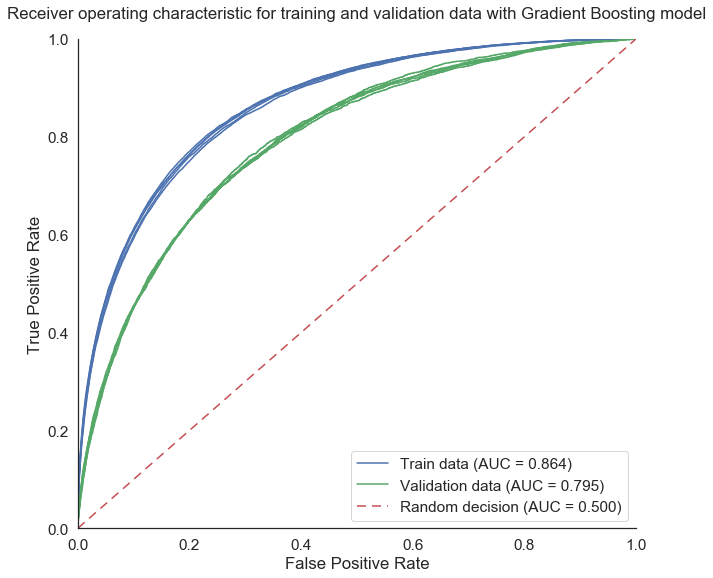

In [15]:
# Cross validation prediction with optimized hyperparameters
predict_lgb = GridSearch_lgb(application_train[features], application_train["TARGET"], param_grid, cv = 5, predict = True)

In [16]:
# Definition of final LightGB model

estimator_param["n_estimators"] = 4500


lgb = LGBMClassifier(boosting_type=estimator_param["boosting_type"],
                     num_leaves=estimator_param["num_leaves"], 
                     max_depth=estimator_param["max_depth"],
                     learning_rate=estimator_param["learning_rate"],
                     n_estimators=estimator_param["n_estimators"], 
                     subsample_for_bin=estimator_param["subsample_for_bin"],
                     objective=estimator_param["objective"],
                     class_weight=estimator_param["class_weight"],
                     min_split_gain=estimator_param["min_split_gain"],
                     min_child_weight=estimator_param["min_child_weight"], 
                     min_child_samples=estimator_param["min_child_samples"],
                     subsample=estimator_param["subsample"],
                     subsample_freq=estimator_param["subsample_freq"],
                     bagging_freq = estimator_param["bagging_freq"],
                     colsample_bytree=estimator_param["colsample_bytree"],
                     reg_alpha=estimator_param["reg_alpha"],
                     reg_lambda=estimator_param["reg_lambda"],
                     random_state=estimator_param["random_state"],
                     n_jobs=estimator_param["n_jobs"],
                     silent=estimator_param["silent"], 
                     importance_type=estimator_param["importance_type"])

In [17]:
# Training of final LightGB model
lgb.fit(application_train[features], application_train["TARGET"])

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.6, importance_type='split', learning_rate=0.01,
        max_depth=5, min_child_samples=45, min_child_weight=0.001,
        min_split_gain=0.5, n_estimators=4500, n_jobs=7, num_leaves=1000,
        objective='binary', random_state=2, reg_alpha=15, reg_lambda=20,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=1.0)

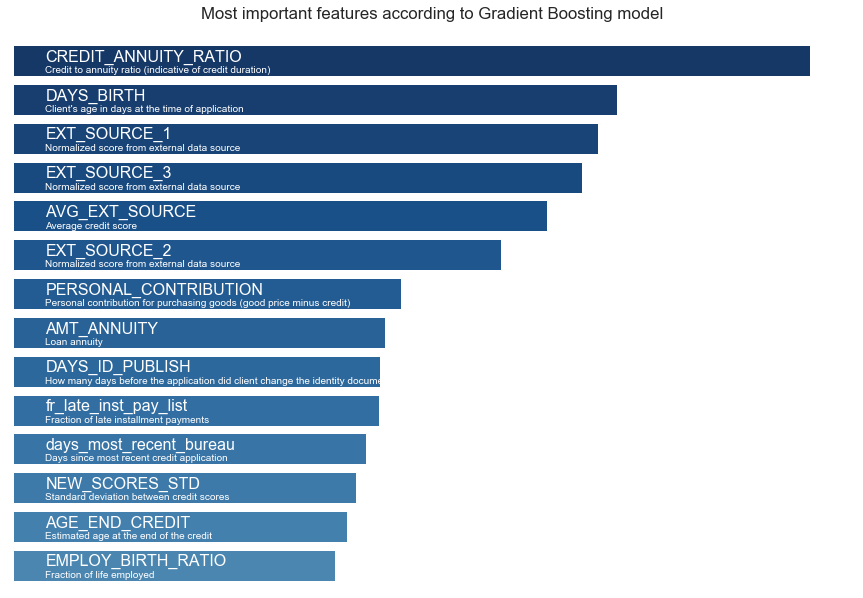

In [18]:
# Plotting features importance for the final LightGB model

plt.figure(figsize=(15,10))
sns.set_style("white")
feature_importance_list = []
for index, importance in enumerate(lgb.feature_importances_):
    feature_importance_list.append([importance, features[index]])
feature_importance_list = sorted(feature_importance_list, reverse = True)[0:14]
labels = [item[1] for item in feature_importance_list]
importances = [item[0] / estimator_param["n_estimators"]  for item in feature_importance_list]

ax = sns.barplot(y = labels, x = importances, palette = sns.color_palette("Blues_r", 40))
ax.tick_params(axis='x', rotation=90, labelleft = True)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

for i, item in enumerate(labels):
    title = homecredit_columns_description[homecredit_columns_description["Row"] == item]["Description"].tolist()[0]
    ax.text(y = i-0.1 , x = min(importances)/10, s = str(labels[i]), size = 16, horizontalalignment='left', verticalalignment = "center", color = "white")
    ax.text(y = i+0.25 , x = min(importances)/10, s = str(title), size = 10, horizontalalignment='left', verticalalignment = "center", color = "white")
sns.despine(left = True, bottom = True)
plt.title("Most important features according to Gradient Boosting model", y = 1.03)
plt.show()

In [19]:
# Predictions of the test data using the final LightGB model
predictions_lgb_test = lgb.predict_proba(application_test[features])[:,1]

In [20]:
predictions_lgb_train = lgb.predict_proba(application_train[features])[:,1]

In [21]:
# Writing predictions into the submission file
predictions_id = application_test["SK_ID_CURR"]
submission_df = {"SK_ID_CURR": predictions_id,
                 "TARGET": predictions_lgb_test}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/submission_lgb.csv",index=False)

## Results

The Lightgb model has a CV AUC score of 0.795 and a Kaggle public leaderboard AUC score of 0.796. The ROC AUC plot shows that, with the optimized hyperparameters, the model overfits the training data since there is a large difference between training and validation AUC score (0.861 vs 0.795). However, we trust these parameters because they have been optimized using Grid Search CV.

## Keras neural network model

A neural network model is also created using Keras to improve the predictions generated using the LightGB model (via a stacked model). This neural network was iteratively optimized manually because a grid search function for neural networks is more complex than for LightGB, due to the different layers.

First, the features are normalized (necessary for the good behavior of the neural network) and then Cross Validation predicition of the training data is perfromed to optimize the model. The AUC metric is calculated for each epoch and the best epoch is retained for the final model.

The neural network model has only one hidden layer, with dropout after the layer and normalization of its weights in order to prevent overfitting. The loss function of the gradient descent is binary cross entropy.

In [22]:
# Filling NA values with -1 (unlike the LightGB model, the Keras NN model does not accept NA values)
application_train_nn = application_train.fillna(-1)
application_test_nn = application_test.fillna(-1)

In [23]:
# Normalization of features
def normalize_features(df1, df2, features):
    for feature in features:
        if len(df1[feature].unique()) <= 2:
            max_val = df1[feature].max()
            min_val = df1[feature].min()
            df1[feature] = (df1[feature] - min_val)/(max_val - min_val)
            df2[feature] = (df2[feature] - min_val)/(max_val - min_val)
        else:
            mean = df1[feature].mean()
            std = df1[feature].std()
            df1[feature] = (df1[feature] - mean)/std
            df2[feature] = (df2[feature] - mean)/std

    return df1[features], df2[features]

application_train_nn[features], application_test_nn[features] = normalize_features(application_train_nn, application_test_nn, features)

In [24]:
# Class to calculate the auc for each epoch so that the best epoch can be retained (to prevent overfitting)

class Histories(Callback):
    def on_train_begin(self, logs={}):
        self.epochs = []
        self.aucs = []
        self.losses = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.epochs.append(epoch)
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0])
        self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
# CV prediction function for Keras neural network model

def CV_predict_keras(X, y, cv, predict = False):
    kfold = KFold(n_splits=cv, shuffle=True, random_state = 2)
    roc_auc_val_list = []
    roc_auc_train_list = []
    fpr_train_list = []
    tpr_train_list = []
    fpr_val_list = []
    tpr_val_list = []
    best_ntree_list = []
    predictions_list = []
    counter = 0
    df_train = pd.DataFrame(index = X.index)
    df_val = pd.DataFrame(index = X.index)
    cv_predict = pd.DataFrame(index = X.index)
    cv_predict["predict_proba"] = np.NaN
    for train_index, val_index in kfold.split(X, y):
        counter += 1
        df_train[str(counter)] = np.NaN
        df_val[str(counter)] = np.NaN
        
        # Definition of training and validation sets for Kfold
        train_X = X.iloc[train_index]
        train_y = y.iloc[train_index]
        val_X = X.iloc[val_index]
        val_y = y.iloc[val_index]
        
        # Definition of model
        model = Sequential()
        model.add(Dense(50, input_dim=len(features), activation="sigmoid", 
                                     kernel_regularizer = regularizers.l2(0.00004)))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation="sigmoid"))

        model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

        monitor = EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 100, 
                                verbose = 0, mode = "auto")
        histories = Histories()


        model.fit(train_X.fillna(-1),
                  train_y.astype(int),
                  callbacks = [monitor, histories],
                  epochs=125,
                  batch_size=10000,
                  validation_data=(val_X, val_y),
                  verbose = 0)
        
        max_auc = max(histories.aucs)
        max_index = histories.aucs.index(max_auc) + 1

        predictions_train = model.predict_proba(train_X.fillna(-1).values, batch_size=32)
        predictions_val = model.predict_proba(val_X.fillna(-1).values, batch_size=32)

        if predict == True:
            cv_predict["predict_proba"].loc[val_index] = predictions_val[:,0]
        
        # Plotting the ROC AUC for each CV fold
        fpr_train, tpr_train, threshold = roc_curve(train_y, predictions_train)
        fpr_val, tpr_val, threshold = roc_curve(val_y, predictions_val)
        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_val = auc(fpr_val, tpr_val)
        print("CV %0.1i : Last/best ROC AUC: %0.3f/%0.3f (Last/best epoch: %0.1i/%0.1i)" 
              % (counter, roc_auc_val, max_auc, len(histories.aucs), max_index))
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_val_list.append(roc_auc_val)
        fpr_train_list.append(fpr_train)
        tpr_train_list.append(tpr_train)
        fpr_val_list.append(fpr_val)
        tpr_val_list.append(tpr_val)
        plt.plot(fpr_train, tpr_train, label = 'Training data AUC = %0.4f' % roc_auc_train)
        plt.plot(fpr_val, tpr_val, label = 'Validation data AUC = %0.4f' % roc_auc_val)
        plt.legend(loc = 'lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        # Plotting the AUC as a function of epoch for each CV fold
        plt.plot(histories.epochs, histories.aucs)
        plt.ylabel('ROC AUC')
        plt.xlabel('Training epoch')
        plt.show()
       
        
    avg_auc_train = np.mean(roc_auc_train_list)
    avg_auc_val = np.mean(roc_auc_val_list)
    std_auc_val = np.std(roc_auc_val_list)
    print("ROC AUC: %0.4f +/- %0.4f" % (avg_auc_val, std_auc_val * 2))

    fig, ax = plt.subplots(figsize=(10,9))
    plt.title("Receiver operating characteristic for training and validation data with Neural Network model", y = 1.03)
    for iteration in range(cv):
        if iteration == 0:
            ax.plot(fpr_train_list[iteration], tpr_train_list[iteration], label = 'Train data (AUC = %0.3f)' % avg_auc_train, color = pal.as_hex()[0])
            ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], label = 'Validation data (AUC = %0.3f)' % avg_auc_val, color = pal.as_hex()[1])
        else:
            ax.plot(fpr_train_list[iteration], tpr_train_list[iteration] , color = pal.as_hex()[0])
            ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], color = pal.as_hex()[1])
    ax.plot([0, 1], [0, 1], dashes = (6,4), color = pal.as_hex()[2], label = "Random decision (AUC = 0.500)")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    sns.despine()
    plt.legend(loc = 'lower right')
   
    if predict == True:
        return cv_predict

CV 1 : Last/best ROC AUC: 0.779/0.780 (Last/best epoch: 125/118)


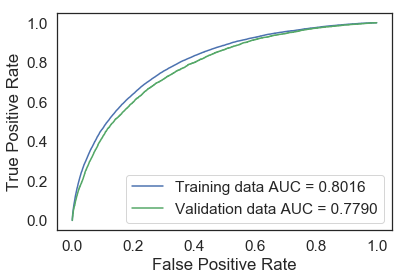

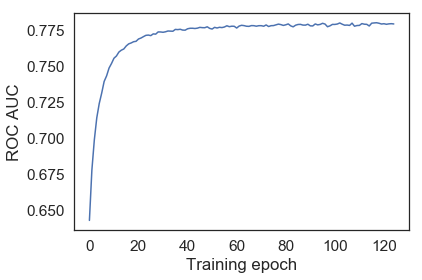

CV 2 : Last/best ROC AUC: 0.783/0.783 (Last/best epoch: 125/107)


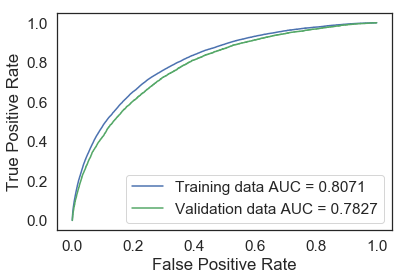

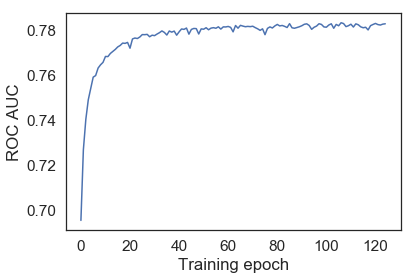

CV 3 : Last/best ROC AUC: 0.782/0.784 (Last/best epoch: 125/122)


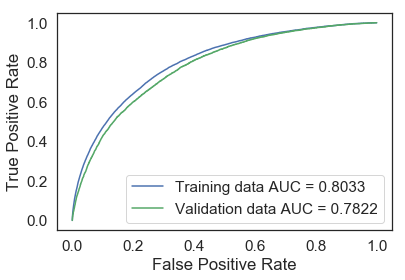

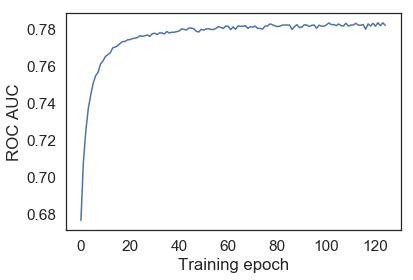

CV 4 : Last/best ROC AUC: 0.783/0.784 (Last/best epoch: 125/124)


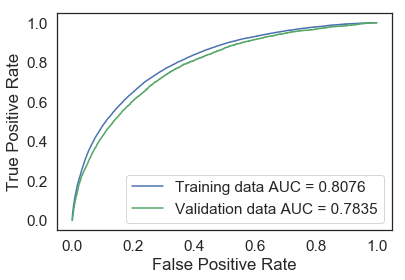

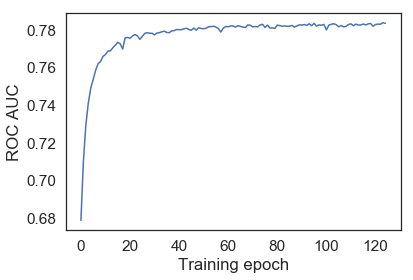

CV 5 : Last/best ROC AUC: 0.778/0.778 (Last/best epoch: 125/116)


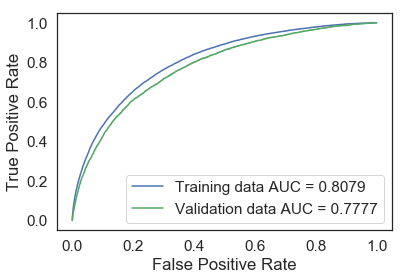

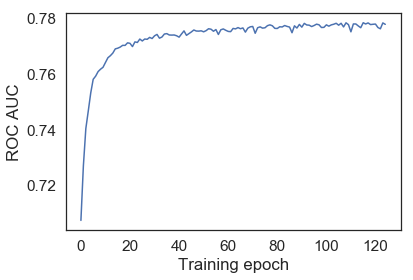

ROC AUC: 0.7810 +/- 0.0045


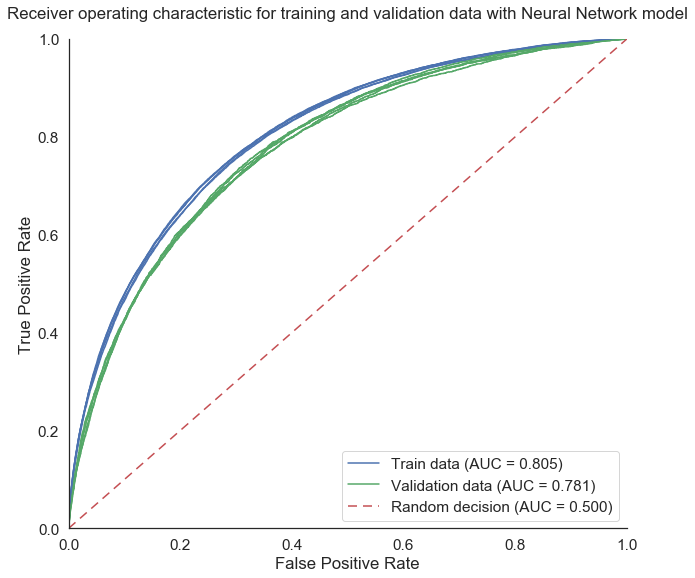

In [ ]:
# Cross validation prediction with manually optimized neural network
predict_nn = CV_predict_keras(application_train_nn[features], application_train_nn["TARGET"], cv = 5, predict = True);

In [ ]:
# Definition of final Keras model

model = Sequential()
model.add(Dense(50, input_dim=len(features), activation="sigmoid", 
                             kernel_regularizer = regularizers.l2(0.00004)))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

model.fit(application_train_nn[features].fillna(-1),
          application_train_nn["TARGET"].astype(int),
          epochs=125,
          batch_size=10000,
          verbose = 0)

predictions_nn_test = model.predict_proba(application_test_nn[features].fillna(-1).values, batch_size=32)[:,0]
predictions_nn_train = model.predict_proba(application_train_nn[features].fillna(-1).values, batch_size=32)[:,0]

In [ ]:
predictions_nn_test = model.predict_proba(application_test_nn[features].fillna(-1).values, batch_size=32)[:,0]
predictions_nn_train = model.predict_proba(application_train_nn[features].fillna(-1).values, batch_size=32)[:,0]

In [35]:
# Writing predictions into the submission file
predictions_id = application_test["SK_ID_CURR"]
submission_df = {"SK_ID_CURR": predictions_id,
                 "TARGET": predictions_nn_test}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/submission_nn.csv",index=False)

## Results

The Keras neural network model has a CV AUC score of 0.781 (much lower than the LGB CV score: 0.795) and a Kaggle public leaderboard AUC score of 0.782 (vs 0.796 for the LGB model). The ROC AUC plot shows that the model does not overfit the training data, mainly thanks to the dropout of hidden neurons in the model.

## Stacked model

Stacked models (linear regression model and linear combination of predicted probabilities) using the LightGB and Keras neural network models are generated to improve the overall prediction.

In [36]:
# Addition of predicted probabilities to training and test datasets
application_train["predict_lgb"] = predict_lgb
application_train["predict_nn"] = predict_nn
application_test["predict_lgb"] = predictions_lgb_test
application_test["predict_nn"] = predictions_nn_test

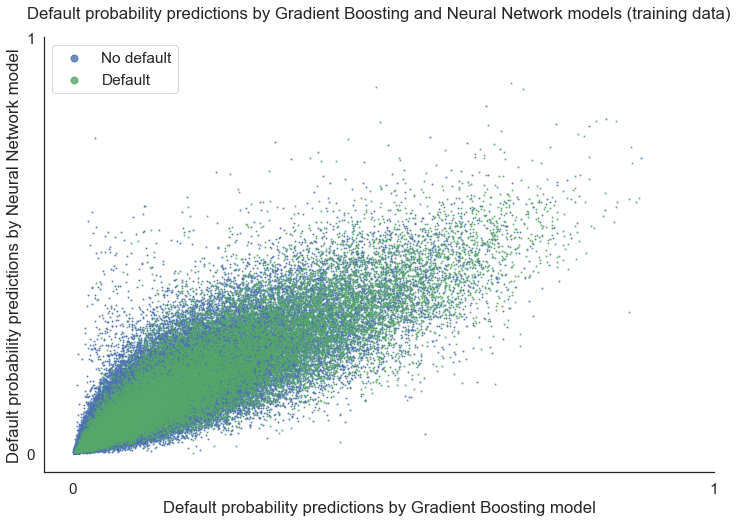

In [37]:
# Plotting probability of default for training data predicted by LightGB model vs neural network model
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(application_train[application_train["TARGET"] == 0]["predict_lgb"], application_train[application_train["TARGET"] == 0]["predict_nn"], alpha = 0.8, s = 1, label = "No default")
plt.scatter(application_train[application_train["TARGET"] == 1]["predict_lgb"], application_train[application_train["TARGET"] == 1]["predict_nn"], alpha = 0.8, s = 1, label = "Default")
plt.xticks([0,1], [0,1])
plt.yticks([0,1], [0,1])
plt.xlabel("Default probability predictions by Gradient Boosting model")
plt.ylabel("Default probability predictions by Neural Network model")
plt.legend(loc ="upper left")
for index in range(2):
    ax.legend_.legendHandles[index].set_color(pal.as_hex()[index])
    ax.legend_.legendHandles[index]._sizes = [49]
sns.despine()
plt.title("Default probability predictions by Gradient Boosting and Neural Network models (training data)", y = 1.03)
plt.show()

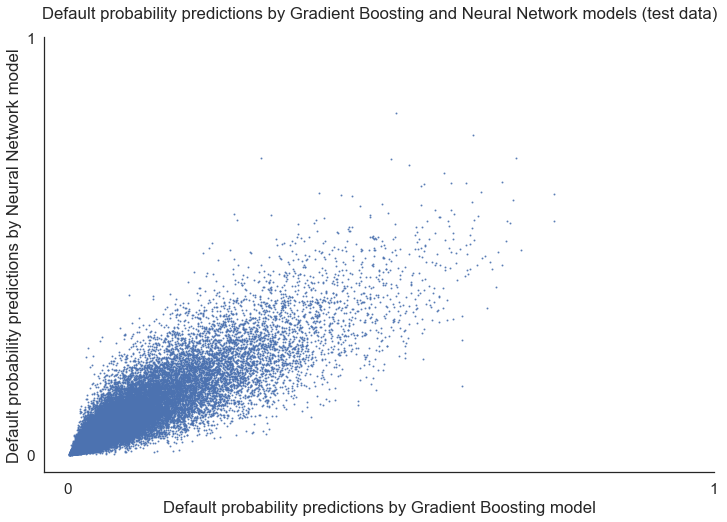

In [38]:
# Plotting probability of default for test data predicted by LightGB model vs neural network model
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(application_test["predict_lgb"], application_test["predict_nn"], alpha = 0.8, s = 1)
plt.xticks([0,1], [0,1])
plt.yticks([0,1], [0,1])
plt.xlabel("Default probability predictions by Gradient Boosting model")
plt.ylabel("Default probability predictions by Neural Network model")
sns.despine()
plt.title("Default probability predictions by Gradient Boosting and Neural Network models (test data)", y = 1.03)
plt.show()

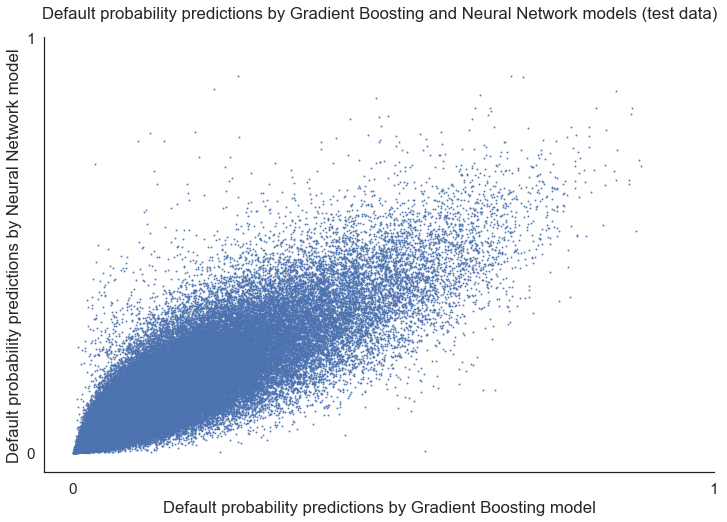

In [39]:
# Plotting probability of default for test data predicted by LightGB model vs neural network model
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(application_train["predict_lgb"], predictions_nn_train, alpha = 0.8, s = 1)
plt.xticks([0,1], [0,1])
plt.yticks([0,1], [0,1])
plt.xlabel("Default probability predictions by Gradient Boosting model")
plt.ylabel("Default probability predictions by Neural Network model")
sns.despine()
plt.title("Default probability predictions by Gradient Boosting and Neural Network models (test data)", y = 1.03)
plt.show()

In [40]:
# Logistic regression stacked model
lr = LogisticRegression()
predict_stacked = cross_val_predict(lr, application_train[["predict_lgb", "predict_nn"]], application_train["TARGET"], cv=5, method='predict_proba')

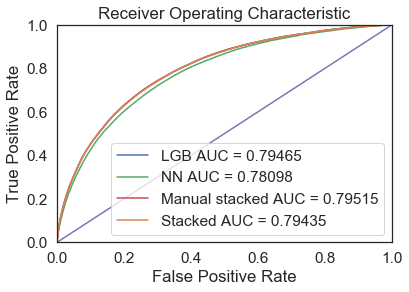

In [41]:
# Plotting the ROC AUC results for the base models and the stacked models (logistic regression and linear combination with manual optimization)
fpr_1, tpr_1, threshold = roc_curve(application_train["TARGET"], predict_lgb)
fpr_2, tpr_2, threshold = roc_curve(application_train["TARGET"], predict_nn)
fpr_3, tpr_3, threshold = roc_curve(application_train["TARGET"], 0.15*predict_nn+ 0.85*predict_lgb)
fpr_4, tpr_4, threshold = roc_curve(application_train["TARGET"], predict_stacked[:,1])

roc_auc_1 = auc(fpr_1, tpr_1)
roc_auc_2 = auc(fpr_2, tpr_2)
roc_auc_3 = auc(fpr_3, tpr_3)
roc_auc_4 = auc(fpr_4, tpr_4)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr_1, tpr_1, label = 'LGB AUC = %0.5f' % roc_auc_1, color = pal.as_hex()[0])
plt.plot(fpr_2, tpr_2, label = 'NN AUC = %0.5f' % roc_auc_2, color = pal.as_hex()[1])
plt.plot(fpr_3, tpr_3, label = 'Manual stacked AUC = %0.5f' % roc_auc_3, color = pal.as_hex()[2])
plt.plot(fpr_4, tpr_4, label = 'Stacked AUC = %0.5f' % roc_auc_4, color = pal.as_hex()[3])

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = pal.as_hex()[4])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [42]:
# Writing prediction for the best performing model (manual linear combination of neural network and LGB models)
predictions = 0.15*application_test["predict_nn"] + 0.85*application_test["predict_lgb"]

In [43]:
# Writing predictions into the submission file
predictions_id = application_test["SK_ID_CURR"]
submission_df = {"SK_ID_CURR": predictions_id,
                 "TARGET": predictions}
submission = pd.DataFrame(submission_df)
submission.to_csv("./data/submission_stack.csv",index=False)

## Results

The manually created stacked model (linear combination of the predicted probabilities by the LightGB and neural network models) has a CV AUC score of 0.796 and a Kaggle public leaderboard AUC score of 0.797 (vs 0.796 for the LGB model).

This model is kept as the final model for Kaggle Home Credit default risk competition and lead to a Kaggle private leaderboard AUC score of 0.79478, which resulted in a ranking of 644th among 7198 competitors (top 9%).

## Analyses

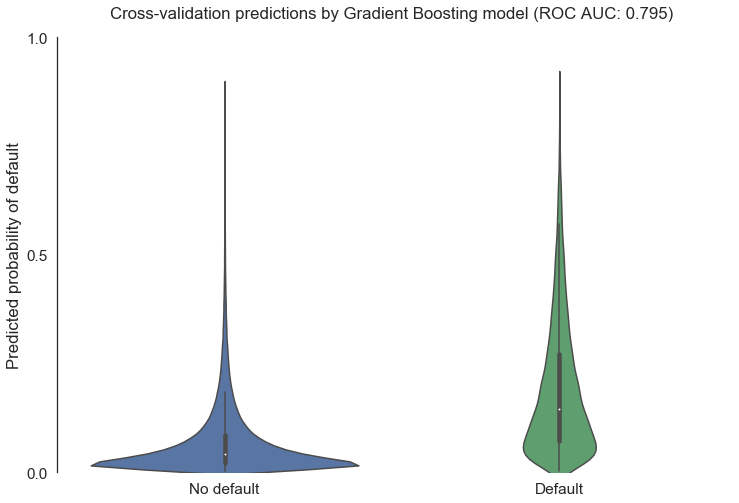

In [44]:
# Plotting CV prediction distribution for both default and non-default credits for training data
fpr, tpr, threshold = roc_curve(application_train["TARGET"], application_train["predict_lgb"])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(x = "TARGET", y = "predict_lgb", data = application_train, 
               orient = "v", palette=pal, ax = ax)
ax.set_xlabel("")
ax.set_ylabel("Predicted probability of default")
ax.set_xticklabels(["No default", "Default"])
ax.set_yticks([0.0, 0.5, 1.0])
ax.set_ylim(0,1)

ax.set_title("Cross-validation predictions by Gradient Boosting model (ROC AUC: %0.3f)" % roc_auc , y = 1.03)
sns.despine(bottom = True)
plt.show()


In [45]:
def improvement_cutoff(cutoff_val):
    initial_avg = application_train["TARGET"].mean()
    final_avg = application_train[application_train["predict_lgb"] < cutoff_val]["TARGET"].mean()
    fr_remaining_customer = len(application_train[application_train["predict_lgb"] < cutoff_val]["TARGET"])/len(application_train)
    print("By selecting customers with a default probability below %0.0f%%, the default rate is reduced by %0.0f%%, while the percentage of accepted applications is %0.0f%%." % (cutoff_val * 100, -(final_avg - initial_avg)/initial_avg * 100, fr_remaining_customer * 100))

In [46]:
improvement_cutoff(0.05)
improvement_cutoff(0.1)
improvement_cutoff(0.2)
improvement_cutoff(0.5)

By selecting customers with a default probability below 5%, the default rate is reduced by 71%, while the percentage of accepted applications is 54%.
By selecting customers with a default probability below 10%, the default rate is reduced by 53%, while the percentage of accepted applications is 75%.
By selecting customers with a default probability below 20%, the default rate is reduced by 31%, while the percentage of accepted applications is 91%.
By selecting customers with a default probability below 50%, the default rate is reduced by 5%, while the percentage of accepted applications is 99%.


In [47]:
predictions_lgb_train = lgb.predict_proba(application_train[features])[:,1]

In [48]:
predictions_nn_train

array([0.270999  , 0.01117153, 0.0301025 , ..., 0.05184251, 0.10911502,
       0.06120914], dtype=float32)

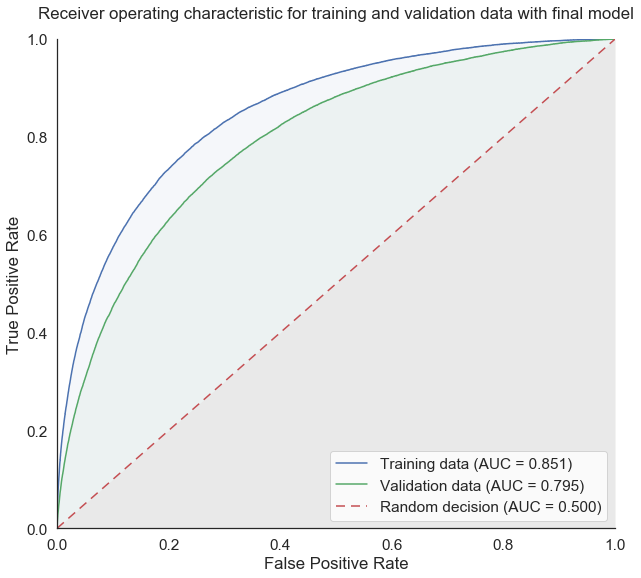

In [49]:
# Plotting ROC curve and AUC for Gradient Boosting model for both training and CV training data
fig, ax = plt.subplots(figsize=(10,9))
fpr_train, tpr_train, threshold = roc_curve(application_train["TARGET"], 0.15*predictions_nn_train + 0.85*predictions_lgb_train)
fpr_val, tpr_val, threshold = roc_curve(application_train["TARGET"], 0.15*application_train["predict_nn"]+0.85*application_train["predict_lgb"])
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)
ax.plot(fpr_train, tpr_train, label = 'Training data (AUC = %0.3f)' % roc_auc_train)
ax.plot(fpr_val, tpr_val, label = 'Validation data (AUC = %0.3f)' % roc_auc_val)
ax.plot([0, 1], [0, 1], dashes = (6,4), label = "Random decision (AUC = 0.500)")
ax.fill_between(fpr_train, tpr_train, 0.0001, alpha = 0.05)
ax.fill_between(fpr_val, tpr_val, 0.0001, alpha = 0.05)
ax.fill_between([0, 1], [0, 1], 0.0001, alpha = 0.05)

plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Receiver operating characteristic for training and validation data with final model", y = 1.03)
plt.xlim(0,1)
plt.ylim(0,1)
sns.despine()
plt.show()

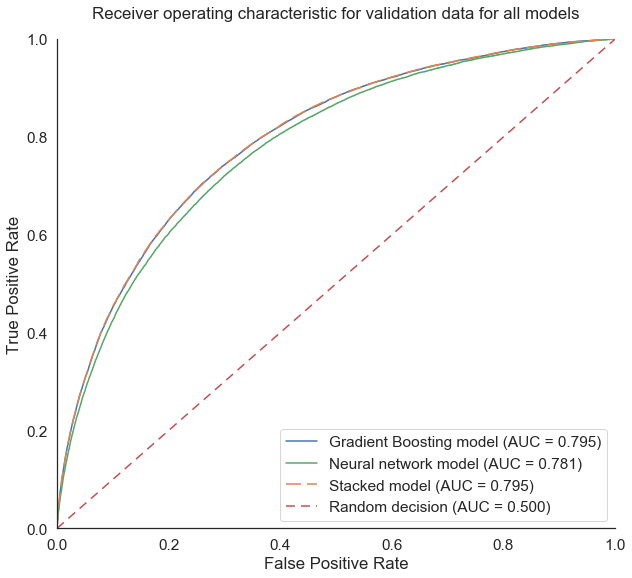

In [50]:
# Plotting ROC curve and AUC for the stacked model for CV training data

fig, ax = plt.subplots(figsize=(10,9))
fpr_lgb, tpr_lgb, threshold = roc_curve(application_train["TARGET"], application_train["predict_lgb"])
fpr_nn, tpr_nn, threshold = roc_curve(application_train["TARGET"], application_train["predict_nn"])
fpr_stacked, tpr_stacked, threshold = roc_curve(application_train["TARGET"], 0.15*application_train["predict_nn"]+0.85*application_train["predict_lgb"])

roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
roc_auc_nn = auc(fpr_nn, tpr_nn)
roc_auc_stacked = auc(fpr_stacked, tpr_stacked)

ax.plot(fpr_lgb, tpr_lgb, label = 'Gradient Boosting model (AUC = %0.3f)' % roc_auc_lgb)
ax.plot(fpr_nn, tpr_nn, label = 'Neural network model (AUC = %0.3f)' % roc_auc_nn)
ax.plot(fpr_stacked, tpr_stacked, label = 'Stacked model (AUC = %0.3f)' % roc_auc_stacked , dashes = (10,4), color = pal.as_hex()[3])
ax.plot([0, 1], [0, 1], dashes = (6,4), label = "Random decision (AUC = 0.500)", color = pal.as_hex()[2])

plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("Receiver operating characteristic for validation data for all models", y = 1.03)
plt.xlim(0,1)
plt.ylim(0,1)
sns.despine()
plt.show()